In [3]:
# optional but useful for debugging - reimports modules after editing and saving .py files
%load_ext autoreload
%autoreload 2

In [147]:
import numpy as np, pandas as pd, scipy
import astropy
from astropy import units as u
import astromet
from astromet.track import design_matrix, design_1d
#import dev.astromet.astromet as astromet
import matplotlib.pyplot as plt
import matplotlib as mpl
import tqdm
import scanninglaw.times
from scanninglaw.source import Source

In [5]:
plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'
mpl.rcParams['lines.linewidth'] = 2.5
mpl.rcParams['axes.facecolor']='white'
mpl.rcParams['axes.edgecolor']='k'
mpl.rcParams['axes.linewidth']=2
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['text.color'] = 'k'
#mpl.rcParams['xtick.major.width'] = 2
#mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['xtick.color']='k'
mpl.rcParams['ytick.color']='k'
mpl.rcParams['axes.labelcolor']='k'

mpl.rcParams['font.size']=12
mpl.rcParams['xtick.direction']='in'
mpl.rcParams['ytick.direction']='in'
mpl.rcParams['xtick.major.size'] = 5.5
mpl.rcParams['ytick.major.size'] = 5.5
mpl.rcParams['xtick.minor.size'] = 3.5
mpl.rcParams['ytick.minor.size'] = 3.5

In [10]:
dr3Period=34/12 # in years
mas=astromet.mas # conversion from degrees to milli-arcseconds

# Load in scanning law
- Requires scanninglaw installed
- Takes up a bit of memory (~1Gb I think)

In [9]:
# slooow step - see scanning_law package for details
dr3_sl=scanninglaw.times.dr2_sl(version='dr3_nominal')

Loading auxilliary data ...
t = 55.569 s
  auxilliary:  26.760 s
          sf:   9.482 s
interpolator:  19.327 s


## Along scan error

In [30]:
# Individual measurement error
sigma_al = np.array(pd.read_csv('astromet/data/scatteral_edr3.csv', usecols=['magbin','var_al_50']))
sigma_al_interp = scipy.interpolate.interp1d(sigma_al[:,0], sigma_al[:,1], bounds_error=False)

# Single source

In [197]:
# System astrometry parameters
params=astromet.params()
params.ra=360*np.random.rand()
params.dec=np.arcsin(-1+2*np.random.rand())*180/np.pi
params.parallax=10*np.power(np.random.rand(),-1/3) # all within 100 pc
params.pmrac=params.parallax*np.random.normal(scale=6.67)
params.pmdec=params.parallax*np.random.normal(scale=6.67)

params.rac = params.ra*np.cos(np.deg2rad(params.dec))
params.pmra = params.pmrac/np.cos(np.deg2rad(params.dec))

params.phot_g_mean_mag=np.random.rand()*6+15

c=Source(params.ra,params.dec,unit='deg')
sl=dr3_sl(c, return_times=True, return_angles=True)
ts=2010+np.squeeze(np.hstack(sl['times']))/365.25
sort=np.argsort(ts)
ts=ts[sort]
phis=np.squeeze(np.hstack(sl['angles']))[sort]

# Get rid of binary signal for the moment
params.a = 0.

In [208]:
rac_track, dec_track=astromet.track(ts,params)

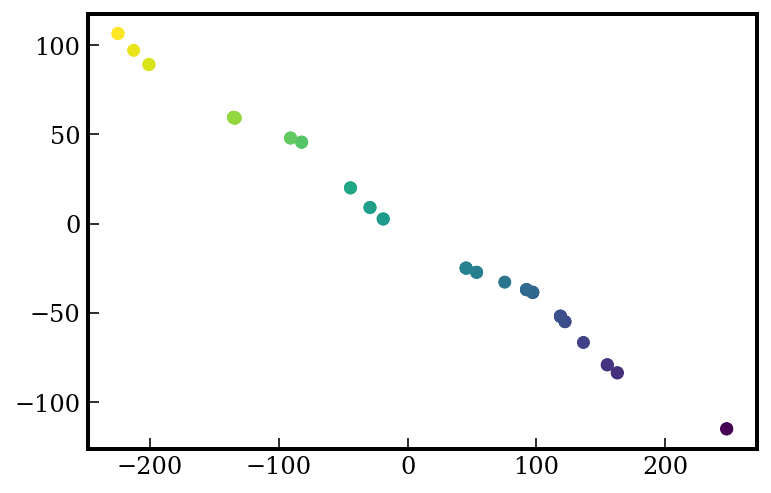

In [214]:
plt.scatter(rac_track-params.rac/astromet.mas, 
            dec_track-params.dec/astromet.mas, c=ts)

In [186]:
x_true = ra_track * np.sin(np.deg2rad(phis)) + dec_track * np.cos(np.deg2rad(phis))
x_err = sigma_al_interp(params.phot_g_mean_mag)

In [190]:
params.ra, params.dec, params.parallax, params.pmrac, params.pmdec

(14.56861937534089,
 53.72654637959002,
 10.08187672248991,
 -52.53427704131727,
 -38.208095088822155)

In [191]:
# 'pmra' in gaia data is pmra*cos(dec) 
results=astromet.gaia_fit(ts,x_true,phis,x_err*0.0001,params.ra,params.dec)
results

{'astrometric_matched_transits': 75,
 'visibility_periods_used': 22,
 'astrometric_n_obs_al': 675,
 'astrometric_params_solved': 31,
 'ra': 14.568619375340637,
 'ra_error': 6.905897409983877e-07,
 'dec': 53.72654637958961,
 'dec_error': 7.411714131655532e-07,
 'ra_dec_corr': -0.41629093611965395,
 'parallax': 10.08187736684977,
 'parallax_error': 1.1722473524833496e-06,
 'ra_parallax_corr': -0.25676074097349477,
 'dec_parallax_corr': 0.24492836287094766,
 'pmra': -52.53427655276854,
 'pmra_error': 9.034212634823377e-07,
 'ra_pmra_corr': -0.492211344825912,
 'dec_pmra_corr': 0.12152244434809197,
 'parallax_pmra_corr': 0.2533887971762855,
 'pmdec': -38.20809613430423,
 'pmdec_error': 8.231466236951325e-07,
 'ra_pmdec_corr': 0.22390250841650777,
 'dec_pmdec_corr': 0.08895082446083627,
 'parallax_pmdec_corr': -0.1898921125501104,
 'pmra_pmdec_corr': -0.5718034710129806,
 'astrometric_excess_noise': 0.0,
 'astrometric_chi2_al': 662.3853585004852,
 'astrometric_n_good_obs_al': 675,
 'UWE': 0

### UWE and astrometric_excess_noise are small!

# Binary source

In [223]:
# System astrometry parameters
params=astromet.params()
params.ra=360*np.random.rand()
params.dec=np.arcsin(-1+2*np.random.rand())*180/np.pi
params.parallax=10*np.power(np.random.rand(),-1/3) # all within 100 pc
params.pmrac=params.parallax*np.random.normal(scale=6.67)
params.pmdec=params.parallax*np.random.normal(scale=6.67)

params.rac = params.ra*np.cos(np.deg2rad(params.dec))
params.pmra = params.pmrac/np.cos(np.deg2rad(params.dec))

params.phot_g_mean_mag=np.random.rand()*6+15

c=Source(params.ra,params.dec,unit='deg')
sl=dr3_sl(c, return_times=True, return_angles=True)
ts=2010+np.squeeze(np.hstack(sl['times']))/365.25
sort=np.argsort(ts)
ts=ts[sort]
phis=np.squeeze(np.hstack(sl['angles']))[sort]

params.period=10**(-1.5+3*np.random.rand()) # periods between 0.03 and 30 years
params.l=np.random.rand() # uniform light ratio
params.q=4*np.random.rand()**2 # mass ratios between 0 and 4 (half less than 1)
params.a=10*np.random.rand()**2
params.e=np.random.rand()
params.vtheta=np.arccos(-1+2*np.random.rand())
params.vphi=2*np.pi*np.random.rand()
params.vomega=2*np.pi*np.random.rand()
orbitalPhase=np.random.rand() # fraction of an orbit completed at t=0
params.tperi=params.period*orbitalPhase

In [224]:
rac_track, dec_track=astromet.track(ts,params)

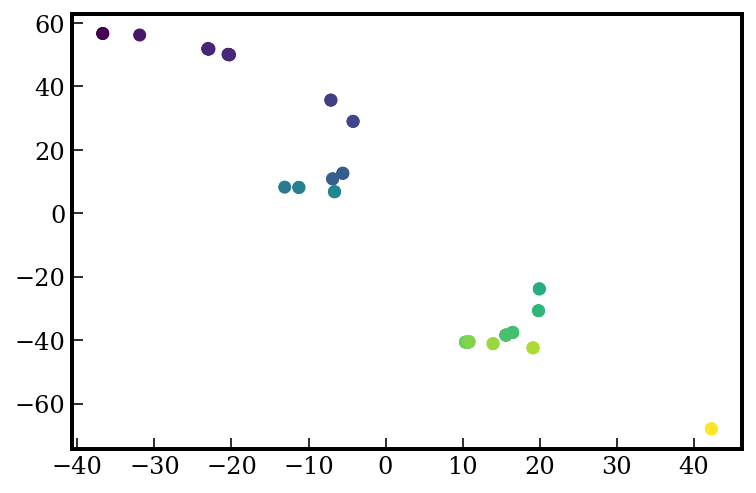

In [225]:
plt.scatter(rac_track-params.rac/astromet.mas, 
            dec_track-params.dec/astromet.mas, c=ts)

In [227]:
x_true = rac_track * np.sin(np.deg2rad(phis)) + dec_track * np.cos(np.deg2rad(phis))
x_err = sigma_al_interp(params.phot_g_mean_mag)

In [228]:
params.ra, params.dec, params.parallax, params.pmrac, params.pmdec

(152.3966888741061,
 -34.31061132265252,
 10.950536188458639,
 23.406452732178735,
 -48.53502767156851)

In [229]:
# 'pmra' in gaia data is pmra*cos(dec) 
results=astromet.gaia_fit(ts,x_true,phis,x_err*0.0001,params.ra,params.dec)
results

{'astrometric_matched_transits': 53,
 'visibility_periods_used': 20,
 'astrometric_n_obs_al': 477,
 'astrometric_params_solved': 31,
 'ra': 152.39668874156544,
 'ra_error': 0.01920825531487972,
 'dec': -34.31061124165928,
 'dec_error': 0.02582984282684921,
 'ra_dec_corr': -0.1393927606117821,
 'parallax': 10.91805430173136,
 'parallax_error': 0.03145981792332477,
 'ra_parallax_corr': 0.10651643047858549,
 'dec_parallax_corr': 0.0556268773234365,
 'pmra': 23.444923677537677,
 'pmra_error': 0.025070280919443796,
 'ra_pmra_corr': 0.12336088570571958,
 'dec_pmra_corr': 0.23625413206545456,
 'parallax_pmra_corr': 0.11290309465104004,
 'pmdec': -48.601208545052835,
 'pmdec_error': 0.03205141998324989,
 'ra_pmdec_corr': 0.248746682583452,
 'dec_pmdec_corr': -0.2554422543000783,
 'parallax_pmdec_corr': 0.1212876763154208,
 'pmra_pmdec_corr': -0.08157389684193221,
 'astrometric_excess_noise': 0.10041575951933687,
 'astrometric_chi2_al': 792406199.8631344,
 'astrometric_n_good_obs_al': 477,
 'UW

### UWE is huuuuge!

# Iterate over many sources

In [222]:
nTest=100
dataNames=('rac','dec','pmrac','pmdec','parallax','phot_g_mean_mag',
           'M_tot','q','l','a','e','P','tPeri',
           'vTheta','vPhi','vOmega',
           'predict_dTheta','simple_dTheta',
           'N_obs','sigma_al','sigma_ac',
           'fit_rac','fit_dec','fit_pmrac','fit_pmdec','fit_parallax',
           'rac_error','dec_error','pmrac_error','pmdec_error','parallax_error',
           'N_vis','frac_good','AEN','UWE'
          )
allData=astropy.table.Table(names=dataNames)

# we'll generate nTest sets of parameters, and test each with a 0, 2 ,5 and 10 mSun BH
for i in tqdm.notebook.tqdm(range(nTest)):
    allData.add_row()
    thisRow=allData[i]
    
    # System astrometry & photometry parameters
    params=astromet.params()
    params.ra=360*np.random.rand()
    params.dec=np.arcsin(-1+2*np.random.rand())*180/np.pi
    params.parallax=10*np.power(np.random.rand(),-1/3) # all within 100 pc
    params.pmra=params.parallax*np.random.normal(scale=6.67)
    params.pmdec=params.parallax*np.random.normal(scale=6.67)
    params.phot_g_mean_mag=np.random.rand()*6+15    
    
    params.rac = params.ra*np.cos(np.deg2rad(params.dec))
    params.pmra = params.pmrac/np.cos(np.deg2rad(params.dec))
    
    # Scanning law information
    c=Source(params.ra,params.dec,unit='deg')
    sl=dr3_sl(c, return_times=True, return_angles=True)
    ts=2010+np.squeeze(np.hstack(sl['times']))/365.25
    sort=np.argsort(ts)
    ts=ts[sort]
    phis=np.squeeze(np.hstack(sl['angles']))[sort]
    
    # Binary parameters
    params.period=10**(-1.5+3*np.random.rand()) # periods between 0.03 and 30 years
    params.l=np.random.rand() # uniform light ratio
    params.q=4*np.random.rand()**2 # mass ratios between 0 and 4 (half less than 1)
    params.a=10*np.random.rand()**2
    params.e=np.random.rand()
    params.vtheta=np.arccos(-1+2*np.random.rand())
    params.vphi=2*np.pi*np.random.rand()
    params.vomega=2*np.pi*np.random.rand()
    orbitalPhase=np.random.rand() # fraction of an orbit completed at t=0
    params.tperi=params.period*orbitalPhase
    
    # Calculate track
    rac_track, dec_track = astromet.track(ts,params)
    x_true = rac_track * np.sin(np.deg2rad(phis)) + dec_track * np.cos(np.deg2rad(phis))
    x_err = sigma_al_interp(params.phot_g_mean_mag)
    
    # Fit with Gaia emulator
    results=astromet.gaia_fit(ts,x_true,phis,x_err,params.ra,params.dec)
    # pmra in results includes the cos(dec) (standard gaia notation)
    
    # Add to dataset
    thisRow['rac']=1.*params.rac
    thisRow['dec']=1.*params.dec
    thisRow['pmrac']=params.pmrac
    thisRow['pmdec']=params.pmdec
    thisRow['parallax']=params.parallax
    thisRow['phot_g_mean_mag']=params.phot_g_mean_mag
    
    thisRow['M_tot']=4*(np.pi**2)*astromet.Galt/((params.period**2)*(params.a**3))
    thisRow['q']=params.q
    thisRow['l']=params.l
    thisRow['a']=params.a
    thisRow['e']=params.e
    thisRow['P']=params.period
    thisRow['tPeri']=1.*params.tperi
    thisRow['vTheta']=params.vtheta
    thisRow['vPhi']=params.vphi
    thisRow['vOmega']=params.vomega
    
    thisRow['simple_dTheta']=astromet.dtheta_simple(params)
    thisRow['predict_dTheta']=astromet.dtheta_full(params,np.min(ts),np.max(ts))  
    
    thisRow['fit_rac']=results['ra']*np.cos(np.deg2rad(results['dec']))
    thisRow['fit_dec']=results['dec']
    thisRow['fit_pmrac']=results['pmra']
    thisRow['fit_pmdec']=results['pmdec']
    thisRow['fit_parallax']=results['parallax']

    thisRow['rac_error']=results['ra_error']
    thisRow['dec_error']=results['dec_error']
    thisRow['pmrac_error']=results['pmra_error']
    thisRow['pmdec_error']=results['pmdec_error']
    thisRow['parallax_error']=results['parallax_error']

    thisRow['UWE']=results['UWE']

  0%|          | 0/100 [00:00<?, ?it/s]

/home/andy/Documents/Research/Projects/GitRepos/astrometpy/astromet/track.py:292: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(epsxsq+epsysq-(epsx**2)-(epsy**2))
/home/andy/Documents/Research/Projects/GitRepos/astrometpy/astromet/track.py:327: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(epsxsq+epsysq-(epsx**2)-(epsy**2))
